# Calculating Tr$\left(\rho^{2}\right)$ from VQE data

In this notebook, we will take quantum circuits built via VQE, and append them to the overlap quantum circuits. 

In [1]:
from sys import path
path.insert(0, '..')
path.insert(0, '../../vqe')

from bba import *
from swap import *
from utilities import *
import numpy as np
import matplotlib.pyplot as plt
import pickle
import variational_form as vf
from qiskit.quantum_info import partial_trace,entropy

The pickled data files contain lists of quantum circuit configurations, with each element describing a disorder configuration. Below is a function that takes in parameters describing the system, and returns a list of quantum circuits.

In [2]:
def load_data(dir_name, W, num_qubits, entanglement, reps):
    fname="{}W{}_q{}_VVQE_SLSQP_{}_rep{}.pkl".format(dir_name, W, num_qubits, entanglement, reps)
    with open(fname,'rb') as f:
        vqe_list = pickle.load(f)
        qc_list = [None]*len(vqe_list)
        for i, vqe in enumerate(vqe_list):
            ansatz = vf.sz_conserved_ansatz(num_qubits, entanglement=entanglement, reps=reps)
            params = sorted(ansatz.parameters, key=lambda p: p.name) 
            params = dict(zip(params, vqe['opt_params'])) 
            qc_list[i] = ansatz.assign_parameters(params)
    return qc_list

Now let's load in some data for $n=4$ qubits, and $W$ ranging from 1 to 8.

In [14]:
num_qubits = 8
dir_name ="../../../results/vvqe/" 
qc_dict = {}
W_list = list(range(1,9))
for W in W_list:
    print("W={}".format(W))
    qc_dict[W] = load_data(dir_name, W, num_qubits, 'sca', 2)

W=1
W=2
W=3
W=4
W=5
W=6
W=7
W=8


Now we connect this circuit to our overlap implementations and collect the second renyi entropys for all disorder and W.

In [15]:
import time
def run_vqe_overlap(qc_dict, overlap_func, shots=1000, noise=None):
    ent_dict = {}
    for W in qc_dict.keys():
        print("W={}".format(W))
        qc_list = qc_dict[W]
        o_list = [0]*len(qc_list)
        for i in range(len(qc_list)):
            print("     {}".format(i))
            psi = qc_list[i]
            n = psi.num_qubits//2
            s = time.time()
            overlap = overlap_func(psi, psi, list(range(n)), shots=shots, backend="qasm_simulator", noise=noise)
            e = time.time()
            print("time: {}".format(e - s))
            o_list.append(-np.log2(overlap))
        ent_dict[W] = o_list
    return ent_dict

In [17]:
sw_ent_dict = run_vqe_overlap(qc_dict, bba_overlap, shots=10000, noise=None)

W=1
     0
time: 0.1563127040863037
     1
time: 0.1456596851348877
     2
time: 0.13001155853271484
     3
time: 0.12757492065429688
     4
time: 0.13372111320495605
     5
time: 0.14801836013793945
     6
time: 0.13573813438415527
     7
time: 0.1827983856201172
     8
time: 0.1470186710357666
     9
time: 0.14499974250793457
     10
time: 0.12301301956176758
     11
time: 0.12945342063903809
     12
time: 0.13282537460327148
     13
time: 0.13196921348571777
     14
time: 0.1368122100830078
     15
time: 0.13105297088623047
     16
time: 0.12709999084472656
     17
time: 0.12858915328979492
     18
time: 0.14793157577514648
     19
time: 0.1538693904876709
     20
time: 0.14588141441345215
     21
time: 0.18446803092956543
     22
time: 0.18396782875061035
     23
time: 0.2083728313446045
     24
time: 0.23302817344665527
     25
time: 0.23772215843200684
     26
time: 0.24417519569396973
     27
time: 0.23519563674926758
     28
time: 0.2222433090209961
     29
time: 0.207241058349

time: 0.2188093662261963
     43
time: 0.19224262237548828
     44
time: 0.20071768760681152
     45
time: 0.19753789901733398
     46
time: 0.19947361946105957
     47
time: 0.19762659072875977
     48
time: 0.20360445976257324
     49
time: 0.19707965850830078
     50
time: 0.19684648513793945
     51
time: 0.19281363487243652
     52
time: 0.21178150177001953
     53
time: 0.264803409576416
     54
time: 0.22277283668518066
     55
time: 0.20377779006958008
     56
time: 0.2212672233581543
     57
time: 0.2273547649383545
     58
time: 0.23869919776916504
     59
time: 0.25760388374328613
     60
time: 0.25501275062561035
     61
time: 0.23376154899597168
     62
time: 0.25994062423706055
     63
time: 0.2246699333190918
     64
time: 0.24278903007507324
     65
time: 0.25311875343322754
     66
time: 0.2524874210357666
     67
time: 0.21719026565551758
     68
time: 0.24222302436828613
     69
time: 0.44428038597106934
     70
time: 0.23874521255493164
     71
time: 0.5037162303924

time: 0.20609617233276367
     85
time: 0.21814703941345215
     86
time: 0.21895647048950195
     87
time: 0.20074200630187988
     88
time: 0.19747567176818848
     89
time: 0.20569252967834473
     90
time: 0.19771218299865723
     91
time: 0.2001352310180664
     92
time: 0.21396374702453613
     93
time: 0.20476722717285156
     94
time: 0.20871734619140625
     95
time: 0.20206546783447266
     96
time: 0.22093915939331055
     97
time: 0.21516633033752441
     98
time: 0.2130873203277588
     99
time: 0.19238615036010742
     100
time: 0.21437430381774902
     101
time: 0.20774149894714355
     102
time: 0.2065119743347168
     103
time: 0.20273208618164062
     104
time: 0.19991207122802734
     105
time: 0.24712753295898438
     106
time: 0.216994047164917
     107
time: 0.20230555534362793
     108
time: 0.21749591827392578
     109
time: 0.23700642585754395
     110
time: 0.22225069999694824
     111
time: 0.20739173889160156
     112
time: 0.19566845893859863
     113
time:

time: 0.2046213150024414
     125
time: 0.19435358047485352
     126
time: 0.19877076148986816
     127
time: 0.25386714935302734
     128
time: 0.2153623104095459
     129
time: 0.23396873474121094
     130
time: 0.2111372947692871
     131
time: 0.21181154251098633
     132
time: 0.1994168758392334
     133
time: 0.22526264190673828
     134
time: 0.2534663677215576
     135
time: 0.21976804733276367
     136
time: 0.23823046684265137
     137
time: 0.20481491088867188
     138
time: 0.24529385566711426
     139
time: 0.1995086669921875
     140
time: 0.20790314674377441
     141
time: 0.20684170722961426
     142
time: 0.21711087226867676
     143
time: 0.21705913543701172
     144
time: 0.24293899536132812
     145
time: 0.22418832778930664
     146
time: 0.21187353134155273
     147
time: 0.21707534790039062
     148
time: 0.1865403652191162
     149
time: 0.2175438404083252
     150
time: 0.2110002040863037
     151
time: 0.2004237174987793
     152
time: 0.22933697700500488
    

time: 0.19684553146362305
     165
time: 0.20867133140563965
     166
time: 0.20922374725341797
     167
time: 0.2021644115447998
     168
time: 0.19446229934692383
     169
time: 0.19813156127929688
     170
time: 0.20039868354797363
     171
time: 0.20265960693359375
     172
time: 0.20194315910339355
     173
time: 0.1990492343902588
     174
time: 0.18598675727844238
     175
time: 0.19210433959960938
     176
time: 0.2010040283203125
     177
time: 0.1999509334564209
     178
time: 0.20501208305358887
     179
time: 0.19405817985534668
     180
time: 0.21767616271972656
     181
time: 0.19495773315429688
     182
time: 0.1944131851196289
     183
time: 0.21327805519104004
     184
time: 0.20320510864257812
     185
time: 0.19819092750549316
     186
time: 0.19750308990478516
     187
time: 0.20833039283752441
     188
time: 0.23305463790893555
     189
time: 0.2092444896697998
     190
time: 0.21167516708374023
     191
time: 0.21955466270446777
     192
time: 0.197235107421875
  

time: 0.17929887771606445
     6
time: 0.18366312980651855
     7
time: 0.17450165748596191
     8
time: 0.15698623657226562
     9
time: 0.5491943359375
     10
time: 0.20681333541870117
     11
time: 0.1575927734375
     12
time: 0.15559840202331543
     13
time: 0.1573958396911621
     14
time: 0.16867494583129883
     15
time: 0.596630334854126
     16
time: 0.16350913047790527
     17
time: 0.15909552574157715
     18
time: 0.18498492240905762
     19
time: 0.19112896919250488
     20
time: 0.1437995433807373
     21
time: 0.14491963386535645
     22
time: 0.14586925506591797
     23
time: 0.14431095123291016
     24
time: 0.13653159141540527
     25
time: 0.16962862014770508
     26
time: 0.1413729190826416
     27
time: 0.14214515686035156
     28
time: 0.13741493225097656
     29
time: 0.14182209968566895
     30
time: 0.14174604415893555
     31
time: 0.14760112762451172
     32
time: 0.1428670883178711
     33
time: 0.1392040252685547
     34
time: 0.14076662063598633
     35

time: 0.13860297203063965
     48
time: 0.13913941383361816
     49
time: 0.13989901542663574
     50
time: 0.13962364196777344
     51
time: 0.1388380527496338
     52
time: 0.13744664192199707
     53
time: 0.1398472785949707
     54
time: 0.13367462158203125
     55
time: 0.14832067489624023
     56
time: 0.14453506469726562
     57
time: 0.1409447193145752
     58
time: 0.1443014144897461
     59
time: 0.14354443550109863
     60
time: 0.1421360969543457
     61
time: 0.14363884925842285
     62
time: 0.13930368423461914
     63
time: 0.1387171745300293
     64
time: 0.13762736320495605
     65
time: 0.13815546035766602
     66
time: 0.13651823997497559
     67
time: 0.13602018356323242
     68
time: 0.1414809226989746
     69
time: 0.13898015022277832
     70
time: 0.13981223106384277
     71
time: 0.13794517517089844
     72
time: 0.1388249397277832
     73
time: 0.1382594108581543
     74
time: 0.13600897789001465
     75
time: 0.1388382911682129
     76
time: 0.13653564453125
 

In [18]:
def get_exact_entropies(qc_dict):

    backend = Aer.get_backend("statevector_simulator")
    ent_dict = {}
    for W in qc_dict.keys():
        print("W={}".format(W))
        qc_list = qc_dict[W]
        o_list = [0]*len(qc_list)
        for i in range(len(qc_list)):
            n = qc_list[i].num_qubits//2
            job = execute(qc_list[i], backend)
            vec = job.result().get_statevector(qc_list[i])
            rho = partial_trace(vec,range(n))
            ent = -np.log2((rho.data@rho.data).trace().real)
            o_list.append(ent)
        ent_dict[W] = o_list
    return ent_dict

In [19]:
exact_ent_dict = get_exact_entropies(qc_dict)

W=1
W=2
W=3
W=4
W=5
W=6
W=7
W=8


<IPython.core.display.Javascript object>


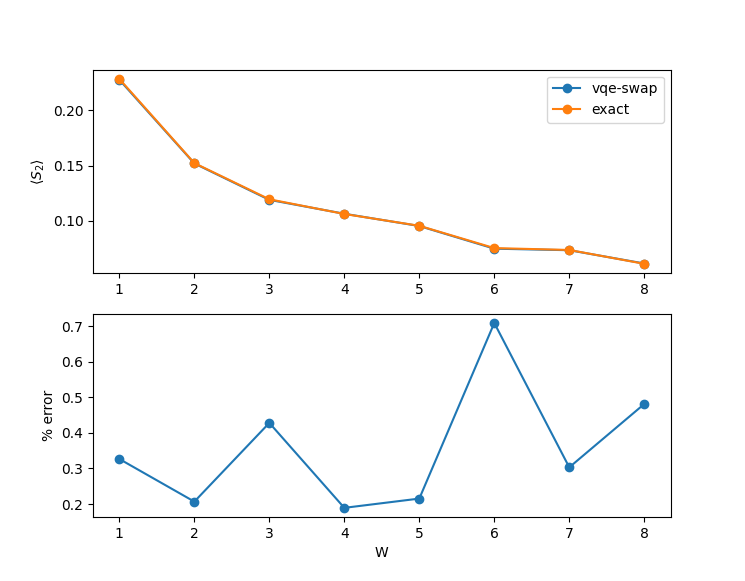

In [20]:

avg_o_list = [np.mean(sw_ent_dict[W]) for W in sw_ent_dict.keys()]
avg_oe_list = [np.mean(exact_ent_dict[W]) for W in exact_ent_dict.keys()]

%matplotlib notebook
#avg_oe_list = [0.5607389420956445, 0.7044439878950863, 0.7887799317531338, 0.8388761771782886, 0.870322646265184, 0.8920924456518833, 0.9082563943417088, 0.9204409755508297]
error_list = [np.abs((a - b)/b)*100 for (a,b) in zip(avg_o_list, avg_oe_list)]
plt.subplot(211)
plt.plot(list(range(1,9)), avg_o_list, 'o-', label='vqe-swap')
plt.plot(list(range(1,9)), avg_oe_list, 'o-', label='exact')
plt.ylabel(r"$\left<S_{2}\right>$")
plt.legend(loc='best')
plt.subplot(212)
plt.plot(list(range(1,9)), error_list, 'o-')
plt.ylabel("% error")
plt.xlabel("W")
plt.show()

In [24]:
print(np.mean(exact_ent_dict[1]))

0.22848544503847237


In [49]:
error_list = []
for i in range(1000):
    psi = qc_list[i]
    overlap = swap_overlap(psi, psi, [0,1], shots=100000, backend="qasm_simulator")
    backend = Aer.get_backend("statevector_simulator")
    job = execute(qc_list[i],backend)
    res = job.result()
    vec = res.get_statevector(qc_list[i])
    num_qubits=4
    rho = partial_trace(vec,range(num_qubits//2))
    S = entropy(rho)
    S2 = (rho.data@rho.data).trace().real
    error_list.append(np.abs(S2 - overlap))
plt.plot(list(range(1000)), error_list)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


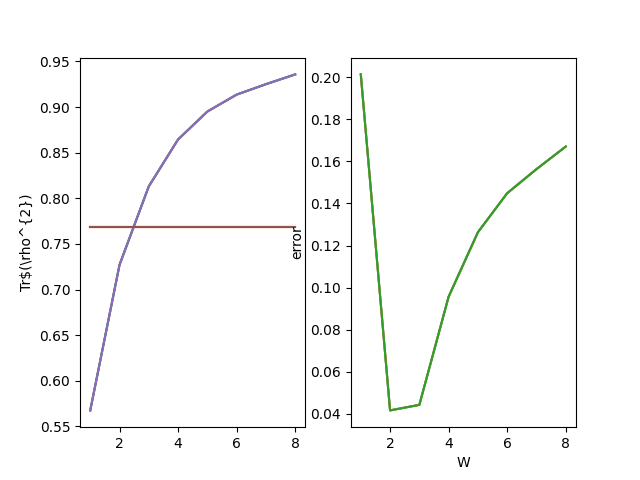

In [52]:
%matplotlib notebook
plt.plot(error_list)
plt.show()